<a href="https://colab.research.google.com/github/alik604/bioMedical-imaging/blob/master/Pneumonia/Chest_X_Ray_Images_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chest X-Ray Images (Pneumonia)
> Khzir Ali Pardhan | AliK604

What I did
* Play around with the CNN for the sample code
* use non-NN, ML with and without PCA and banchmark it
* Try a Hidden Markov Model 

// TODO
* get CNN to get good result. Maybe use the one from the 2nd sample code

Sources
* [Main](https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution)
* Some notebook I found

# Precision/Recall Optimisation
This notebook will walk you through the process of building a Machine Learning model for predicting if a patient **has pneumonia** or **not** based on their X-ray image.

![alt text](https://raw.githubusercontent.com/ZackAkil/machine-learning-trenches-and-highways/master/misc/xray.png)


In [2]:
# !gsutil cp gs://meetup-datasets/pneumonia.obj .
# import os.path

# # check if dataset file exists
# if os.path.isfile('pneumonia.obj'):
#     print('exists')
# else:
#     print('missing, try downloading the data again')


# import numpy as np
# import pickle 

# # [TASK] Specifying the filename of the dataset
# # YOUR CODE STARTS HERE

# file_name = "pneumonia.obj"

# # YOUR CODE ENDS HERE

# print(file_name)
# # submit_answer('task_3', file_name)

# # open dataset file
# with open(file_name, 'rb') as file: 
#   data = pickle.load(file)  

# print(data.keys())

# print(data['label_names'])

# Data Prep

In [1]:
%%bash 

mkdir /root/.kaggle
echo '{"username":"alik604","key":"6e784fca0ed66a5f41b997590bb5371e"}' > /root/.kaggle/kaggle.json
cat /root/.kaggle/kaggle.json
kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
unzip -q chest-xray-pneumonia.zip
ls chest_xray/
ls chest_xray/train/
# ls chest_xray/train/NORMAL

{"username":"alik604","key":"6e784fca0ed66a5f41b997590bb5371e"}
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


mkdir: cannot create directory ‘/root/.kaggle’: File exists
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [ls chest_]
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [xray/]
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [ls chest_]
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [xray/trai]
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace chest_xray/__MACOSX/chest_xray/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [# ls ches]
replace chest_xray/__MACOSX/chest_xray/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [t_xray/tr]
replace chest_xray/__MACOSX/chest_xray/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [ain/NORMA]
replace chest_x

In [2]:
import os, gc, sys
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras 
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, roc_auc_score, auc

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42) # does not work. might be a TF scope issue... I dont care, i prefer PyTorch anyways
# print(tf.random.uniform([1]))  # generates 'A1'
# print(tf.random.uniform([1]))  # generates 'A1'
# print(tf.random.uniform([1]))  # generates 'A1'

In [3]:
data_dir = Path('./chest_xray')

train_dir = data_dir/'train'
val_dir = data_dir/'val'
test_dir = data_dir/'test'

normal_cases_dir = train_dir/'NORMAL'
pneumonia_cases_dir = train_dir/'PNEUMONIA'
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# We will insert the data into this list in (img_path, label) format
# Go through all the normal cases. The label for these cases will be 0
train_data = [(img,0) for img in normal_cases]

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.0).reset_index(drop=True) # `drop=True` don't preserve index by turning it into a column

train_data.head()

,image,label
0,chest_xray/train/PNEUMONIA/person1034_bacteria...,1
1,chest_xray/train/NORMAL/IM-0122-0001.jpeg,0
2,chest_xray/train/PNEUMONIA/person498_bacteria_...,1
3,chest_xray/train/PNEUMONIA/person1156_bacteria...,1
4,chest_xray/train/PNEUMONIA/person97_virus_180....,1


1    3875
0    1341
Name: label, dtype: int64


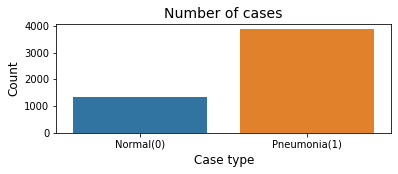

In [4]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(6,2))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

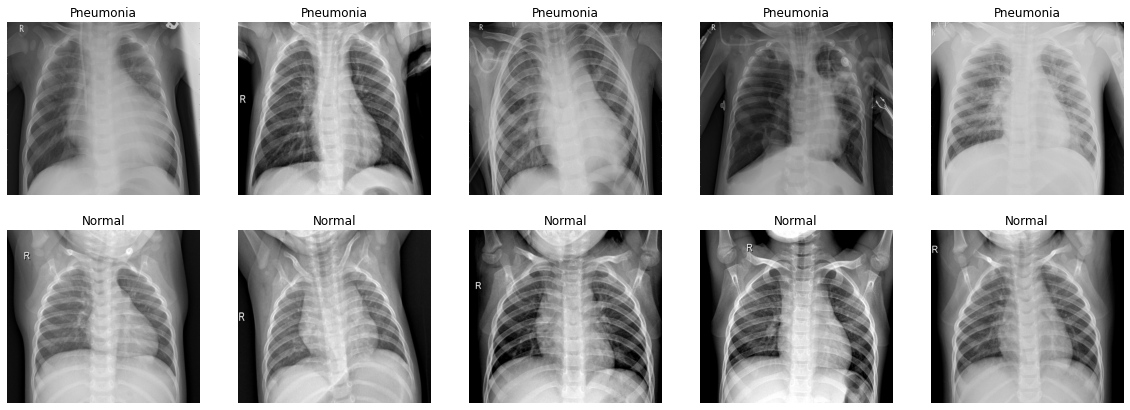

In [5]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(20,7))
for i in range(10):
    img = plt.imread(samples[i])

    ax_row_col_pos = ax[i//5, i%5]
    ax_row_col_pos.imshow(img, cmap='gray')

    if i<5: ax_row_col_pos.set_title("Pneumonia")
    else: ax_row_col_pos.set_title("Normal")

    ax_row_col_pos.axis('off')
    ax_row_col_pos.set_aspect('auto')
    
plt.show()

del pneumonia_samples, normal_samples, samples

In [6]:
RESOLUTION = 98 #64 #224

In [7]:
import cv2 
from keras.utils import to_categorical

# Get the path to the sub-directories
normal_cases_dir = val_dir/'NORMAL'
pneumonia_cases_dir = val_dir/'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []

# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (RESOLUTION,RESOLUTION))
    if img.shape[2] == 1:
        print(img.shape)
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # COLOR_BGR2RGB
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (RESOLUTION,RESOLUTION))
    if img.shape[2] ==1:
        print(img.shape)
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # COLOR_BGR2RGB
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (16, 98, 98)
Total number of labels: (16, 2)


In [8]:
import imgaug.augmenters as iaa

# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

def data_gen(data):
    # Get total number of samples in the data
    n = len(data)

    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((n, RESOLUTION, RESOLUTION), dtype=np.float32) # , 3
    batch_labels = np.zeros((n,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)

    # Initialize a counter
    count = 0
    while count < n-1:
        print(f'Count: {count}, n: {n}')
        # np.random.shuffle(indices)
        # Get the next batch 
        # next_batch = indices[(i*n):(i+1)*n]
        for j, idx in enumerate(indices): # next_batch
            if idx % 750 == 0:
              print(f'idx: {idx}, n: {n}')

            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (RESOLUTION,RESOLUTION))
            
            # check if it's grayscale
            if img.shape[2]==1:
                print(img.shape)
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # COLOR_BGR2RGB
            # normalize the image pixels
            orig_img = orig_img.astype(np.float32)/255.
  
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            batch_labels[count] = encoded_label

            batch_data[count] = orig_img
            
            # generating more samples of the undersampled class
            if label==0 and count < n-3:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2GRAY) # COLOR_BGR2RGB
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2GRAY) # COLOR_BGR2RGB
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=3  
            else:
                count+=1
            if count==n-1:
                print("Break*")
                break 
            elif count>=n:
                print(f'ERROR.... Count: {count}, n: {n}')
                break 
 
    return batch_data, batch_labels

batch_data, batch_labels = data_gen(data=train_data)

Count: 0, n: 5216
idx: 0, n: 5216
idx: 750, n: 5216
idx: 1500, n: 5216
idx: 2250, n: 5216
idx: 3000, n: 5216
Break*


In [9]:
X_train = batch_data#.copy() # too much ram
y_train = batch_labels#.copy()

print(X_train.shape)
print(y_train.shape)

(5216, 98, 98)
(5216, 2)


# CNN

## Note
Reducing `RESOLUTION` yields much better time:performance
tested with 64 and 244. maybe [64..150] will have the ideal middle ground

In [26]:
def build_model():
    model = Sequential()
    # input_img = tf.keras.Input(shape=(RESOLUTION,RESOLUTION,3), name='ImageInput')
    model.add(Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1', input_shape = (RESOLUTION,RESOLUTION, 1))) # 
    model.add(Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2'))
    model.add(SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1'))

    model.add(SpatialDropout2D(0.1)) # Speed up

    # model.add(SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2'))
    # model.add(MaxPooling2D((2,2), name='pool2'))
    # model.add(SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1'))
    model.add(BatchNormalization(name='bn1'))
    # model.add(SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2'))
    # model.add(BatchNormalization(name='bn2'))
    # model.add(SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3'))
    # model.add(MaxPooling2D((2,2), name='pool3'))
    # model.add(SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1'))
    # model.add(BatchNormalization(name='bn3'))
    # model.add(SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')) # was 512
    # model.add(BatchNormalization(name='bn4'))
    model.add(SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv4_3')) # was 512


    # added/change by me
    model.add(MaxPooling2D((5,5), name='pool4'))
    model.add(SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv4_4')) # was 512
    # model.add(SpatialDropout2D(0.5))

    model.add(Flatten(name='flatten'))
    # model.add(Dense(1028, activation='relu', name='fc1'))
    # model.add(Dropout(0.7, name='dropout1'))
    model.add(Dense(512, activation='relu', name='fc2'))
    model.add(Dropout(0.5, name='dropout2'))
    model.add(Dense(2, activation='softmax', name='fc3'))

    return model

model = build_model()
model.build()
model.summary()

opt = keras.optimizers.Adam() # lr=0.0001, decay=1e-5
es = keras.callbacks.EarlyStopping(patience=5)
chkpt = keras.callbacks.ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1_1 (Conv2D)             (None, 98, 98, 64)        640       
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 98, 98, 64)        36928     
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 98, 98, 128)       8896      
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 98, 98, 128)       0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 98, 98, 128)       512       
_________________________________________________________________
Conv4_3 (SeparableConv2D)    (None, 98, 98, 128)       17664     
_________________________________________________________________
pool4 (MaxPooling2D)         (None, 19, 19, 128)      

In [27]:
shape = list(X_train.shape)
X_train_reshaped = X_train.reshape(shape[0], shape[1], shape[2], -1)

shape = list(valid_data.shape)
valid_data_reshaped = valid_data.reshape(shape[0], shape[1], shape[2], -1)

In [28]:
batch_size = 32 # 16 is ideal for low res, # 32 will be faster good for high res
nb_epochs = 7

# Fit the model
history = model.fit(X_train_reshaped, y_train, epochs=nb_epochs, batch_size=batch_size, validation_data=(valid_data_reshaped, valid_labels), callbacks=[es, chkpt],  class_weight={0:1.0, 1:0.4})

Epoch 1/7
163/163 [==============================] - 32s 195ms/step - loss: 0.1407 - accuracy: 0.8698 - val_loss: 1.3951 - val_accuracy: 0.5000
Epoch 2/7
163/163 [==============================] - 26s 162ms/step - loss: 0.0569 - accuracy: 0.9630 - val_loss: 1.7146 - val_accuracy: 0.5000
Epoch 3/7
163/163 [==============================] - 27s 165ms/step - loss: 0.0350 - accuracy: 0.9768 - val_loss: 0.6852 - val_accuracy: 0.7500
Epoch 4/7
163/163 [==============================] - 27s 169ms/step - loss: 0.0229 - accuracy: 0.9849 - val_loss: 0.1278 - val_accuracy: 0.9375
Epoch 5/7
163/163 [==============================] - 27s 168ms/step - loss: 0.0192 - accuracy: 0.9862 - val_loss: 0.0236 - val_accuracy: 1.0000
Epoch 6/7
163/163 [==============================] - 27s 164ms/step - loss: 0.0177 - accuracy: 0.9872 - val_loss: 0.1935 - val_accuracy: 0.8750
Epoch 7/7
163/163 [==============================] - 26s 162ms/step - loss: 0.0127 - accuracy: 0.9902 - val_loss: 0.5036 - val_accuracy:

### Given that the Valadation set is so tiny, its really damn hard to get > 0.95 Accuracy. Recall that `15/16 = 0.9375`. I don't expect 100% or for the stars allign for the 16/16 to be correct 

In [29]:
print(X_train.shape)
print(valid_data.shape)

(5216, 98, 98)
(16, 98, 98)


In [36]:
# Preparing test data
normal_cases_dir = test_dir/'NORMAL'
pneumonia_cases_dir = test_dir/'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (RESOLUTION,RESOLUTION))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (RESOLUTION,RESOLUTION))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 98, 98)
Total number of labels: (624, 2)


In [31]:
y_test = []
for i in test_labels:
  if i[0] == 1:
    y_test.append(1)
  else:
    y_test.append(0)

In [37]:
shape = list(test_data.shape)
shape
test_data_reshaped = test_data.reshape(shape[0], shape[1], shape[2], -1)

# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data_reshaped, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

# Get predictions
pred = model.predict(test_data_reshaped, batch_size=16)
pred = np.argmax(pred, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(pred.shape)

39/39 [==============================] - 1s 16ms/step - loss: 1.6310 - accuracy: 0.7147
Loss on test set:  1.6310455799102783
Accuracy on test set:  0.7147436141967773
(624,)
(624,)


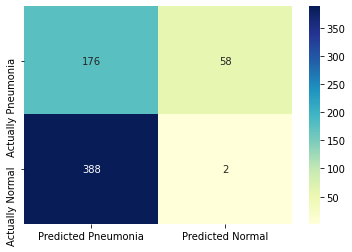

precision - 0.312
recall    - 0.752


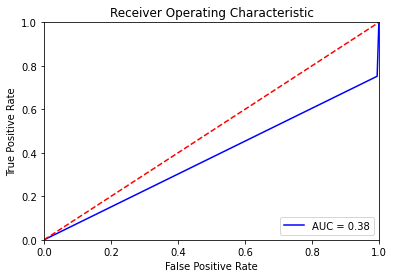

In [38]:
# generate confusion matrix scores
confusion_matrix_scores = confusion_matrix(y_test, pred, labels=[1, 0])

# display scores as a heatmap
df = pd.DataFrame(confusion_matrix_scores, 
                  columns = ["Predicted Pneumonia", "Predicted Normal"],
                  index   = ["Actually Pneumonia", "Actually Normal"])

sns.heatmap(df, annot=True, fmt="d", cmap="YlGnBu")
plt.show()

tp, fn, fp, tn = confusion_matrix_scores.ravel()

precision = tp / ( tp + fp )
recall =  tp / ( tp + fn )

print(f'precision - {precision:.3f}')
print(f'recall    - {recall:.3f}')

# ROC plot
roc_curve(y_test, pred, pos_label=1)
fpr, tpr, threshold = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

# https://stackoverflow.com/a/38467407
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [39]:
# Calculate Precision and Recall
tn, fp, fn, tp = confusion_matrix_scores.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.01
Precision of the model is 0.03


### Goal

I took this code from [here](https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution) and he got 

```
Recall of the model is 0.98
Precision of the model is 0.79
```

# PCA on images

In [10]:
X_train_flatten = np.array([i.flatten() for i in X_train[:500]])
print(X_train_flatten.shape)

from sklearn.decomposition import PCA, KernelPCA
wanted_explained_variance_ratio = 0.90
steps_down = 50
wanted_n_components = min(X_train_flatten.shape)
first_time = True

for i in range(min(X_train_flatten.shape)-1, 1, -steps_down):
  total_var_ratio = round(np.sum(PCA(n_components=i).fit(X_train_flatten).explained_variance_ratio_), 5)
  print('i =', i, 'with a variance ratio of', total_var_ratio)
  if total_var_ratio < wanted_explained_variance_ratio and first_time:
    wanted_n_components = i + steps_down
    # first_time = False

print("We should set n_components to: {wanted_n_components}")

(500, 9604)
i = 499 with a variance ratio of 1.0
i = 449 with a variance ratio of 1.0
i = 399 with a variance ratio of 0.99995
i = 349 with a variance ratio of 0.99906
i = 299 with a variance ratio of 0.99472
i = 249 with a variance ratio of 0.98777
i = 199 with a variance ratio of 0.97716
i = 149 with a variance ratio of 0.96022
i = 99 with a variance ratio of 0.93054
i = 49 with a variance ratio of 0.86937
We should set n_components to: {wanted_n_components}


(500, 9604)
0.99995553
(500, 400)


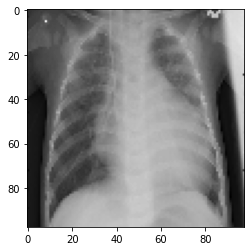

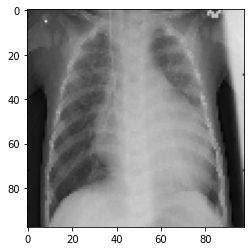

In [11]:
tmp = np.array([i.flatten() for i in X_train[:500]])
print(tmp.shape)

pca = PCA(n_components=400) # 1.0 
reduct = pca.fit_transform(tmp)
print(np.sum(pca.explained_variance_ratio_))
print(reduct.shape)
out = pca.inverse_transform(reduct)

plt.imshow(X_train[0], cmap='gray')
plt.show()

plt.imshow(out[0].reshape(98,98), cmap='gray')
plt.show()

(500, 9604)
0.98793733
(500, 250)


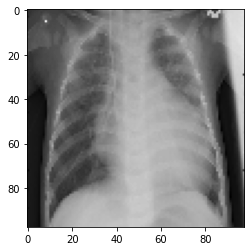

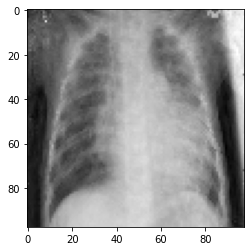

In [12]:
print(tmp.shape)

pca = PCA(n_components=250) # 0.985
reduct = pca.fit_transform(tmp)
print(np.sum(pca.explained_variance_ratio_))
print(reduct.shape)
out = pca.inverse_transform(reduct)

plt.imshow(X_train[0], cmap='gray')
plt.show()

plt.imshow(out[0].reshape(98,98), cmap='gray')
plt.show()

(500, 9604)
0.970103
(500, 175)
Shrunk down to 0.0182% of the DataPoints and expanded back


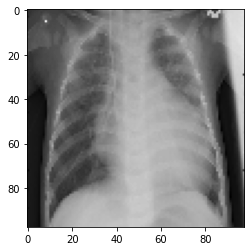

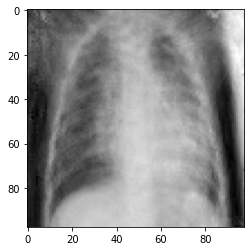

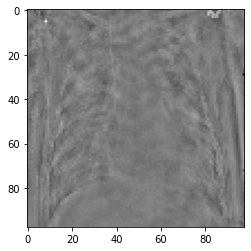

In [13]:
print(tmp.shape)

pca = PCA(n_components=175) #
reduct = pca.fit_transform(tmp)
print(np.sum(pca.explained_variance_ratio_))
print(reduct.shape)
print(f'Shrunk down to {87500/4802000:.4f}% of the DataPoints and expanded back')
out = pca.inverse_transform(reduct)

plt.imshow(X_train[0], cmap='gray')
plt.show()

plt.imshow(out[0].reshape(98,98), cmap='gray')
plt.show()


diff = X_train[0] - out[0].reshape(98,98)
plt.imshow((diff), cmap='gray')
plt.show()


(500, 9604)
0.93132097
(500, 100)


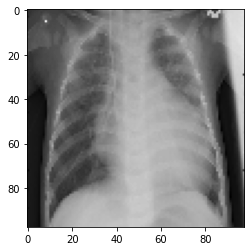

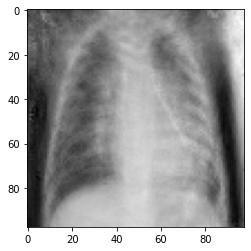

In [14]:
print(tmp.shape)

pca = PCA(n_components=100) # 0.927
reduct = pca.fit_transform(tmp)
print(np.sum(pca.explained_variance_ratio_))
print(reduct.shape)
out = pca.inverse_transform(reduct)

plt.imshow(X_train[0], cmap='gray')
plt.show()

plt.imshow(out[0].reshape(98,98), cmap='gray')
plt.show()

(500, 9604)
0.84995085
(500, 40)


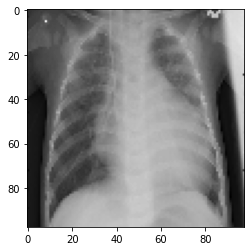

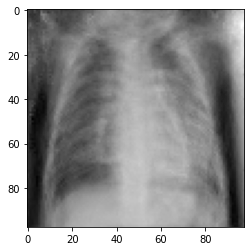

In [15]:
print(tmp.shape)

pca = PCA(n_components=40)
reduct = pca.fit_transform(tmp)
print(np.sum(pca.explained_variance_ratio_))
print(reduct.shape)
out = pca.inverse_transform(reduct)

plt.imshow(X_train[0], cmap='gray')
plt.show()

plt.imshow(out[0].reshape(98,98), cmap='gray')
plt.show()

In [16]:
%%capture
!pip install scikit-plot
!pip install catboost
!pip install mlxtend

from sklearn.model_selection import train_test_split
from sklearn.decomposition import * 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import *

import xgboost  # xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier
import lightgbm # lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
import catboost # catboost.ai/docs/concepts/python-quickstart.html

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from datetime import datetime

In [17]:
X_train.flatten().reshape(X_train.shape[0],-1).shape

(5216, 9604)

In [18]:
X_train.shape

X_train_flatten = X_train.flatten().reshape(X_train.shape[0],-1) # np.array([i.flatten() for i in X_train])
X_train_flatten.shape
y_train.shape

n_samples = 5000

y_train_list = []
for i in y_train:
  if i[0] == 1:
    y_train_list.append(1)
  else:
    y_train_list.append(0)
y_train_list[:10]

(5216, 98, 98)

(5216, 9604)

(5216, 2)

[0, 1, 1, 1, 0, 0, 0, 0, 1, 1]

In [61]:
start = datetime.now()

DTC = DecisionTreeClassifier(random_state=42) 
RFC = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
ETC = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)
XGB = xgboost.XGBClassifier(n_estimators=75, random_state=42, n_jobs=-1)
GBM = lightgbm.LGBMClassifier(n_estimators=50, random_state=42, n_jobs=-1)

list_of_CLFs_names = []
list_of_CLFs = [DTC, RFC, ETC, XGB, GBM]
ranking = []

for clf in list_of_CLFs: 
    _ = clf.fit(X_train_flatten[:n_samples], y_train_list[:n_samples])
    pred = clf.score(X_train_flatten[:n_samples*2], y_train_list[:n_samples*2]) #(X_test,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

print(f'Time Taken: {datetime.now() - start}')

Acc: 0.99655 for the DecisionTreeClassifier
Acc: 0.99808 for the RandomForestClassifier
Acc: 0.99732 for the ExtraTreesClassifier
Acc: 0.99463 for the XGBClassifier
Acc: 0.99789 for the LGBMClassifier
Time Taken: 0:03:51.244108


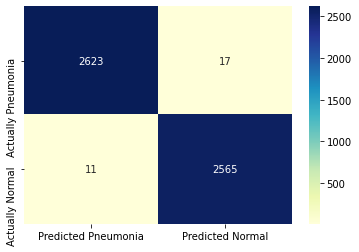

precision - 0.996
recall    - 0.994


In [62]:
clf = list_of_CLFs[3]
pred = clf.predict(X_train_flatten)

confusion_matrix_scores = confusion_matrix(y_train_list, pred, labels=[1, 0])
df = pd.DataFrame(confusion_matrix_scores, 
                  columns = ["Predicted Pneumonia", "Predicted Normal"],
                  index   = ["Actually Pneumonia", "Actually Normal"])

sns.heatmap(df, annot=True, fmt="d", cmap="YlGnBu")
plt.show()

tp, fn, fp, tn = confusion_matrix_scores.ravel()
precision = tp / ( tp + fp )
recall =  tp / ( tp + fn )

print(f'precision - {precision:.3f}')
print(f'recall    - {recall:.3f}')

In [63]:
pca = PCA(n_components=100) # 0.8781622
X_train_flatten_reduct = pca.fit_transform(X_train_flatten)
print("explained_variance_ratio_ ", np.sum(pca.explained_variance_ratio_))
print(X_train_flatten_reduct.shape)
t = X_train_flatten_reduct.shape[0] * X_train_flatten_reduct.shape[1]
b = X_train_flatten.shape[0] * X_train_flatten.shape[1]
print(f'We have {t/b:.4f}% of the DataPoints we would otherwise have')

start = datetime.now()

DTC = DecisionTreeClassifier(random_state=42) 
RFC = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
ETC = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)
XGB = xgboost.XGBClassifier(n_estimators=75, random_state=42, n_jobs=-1)
GBM = lightgbm.LGBMClassifier(n_estimators=50, random_state=42, n_jobs=-1)
list_of_CLFs_names = []
list_of_CLFs = [DTC, RFC, ETC, XGB, GBM]
ranking = []

for clf in list_of_CLFs: 
    _ = clf.fit(X_train_flatten_reduct[:n_samples], y_train_list[:n_samples])
    pred = clf.score(X_train_flatten_reduct[:n_samples*2], y_train_list[:n_samples*2]) #(X_test,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

print(f'Time Taken: {datetime.now() - start}')

explained_variance_ratio_  0.87779474
(5216, 100)
We have 0.0104% of the DataPoints we would otherwise have
Acc: 0.99463 for the DecisionTreeClassifier
Acc: 0.99732 for the RandomForestClassifier
Acc: 0.99789 for the ExtraTreesClassifier
Acc: 0.97182 for the XGBClassifier
Acc: 0.99636 for the LGBMClassifier
Time Taken: 0:00:09.370281


In [64]:
pca = KernelPCA(n_components=100) # , fit_inverse_transform=True
X_train_flatten_reduct = pca.fit_transform(X_train_flatten)
print(X_train_flatten_reduct.shape)
print(f'We have {t/b:.4f}% of the DataPoints we would otherwise have')

start = datetime.now()

DTC = DecisionTreeClassifier(random_state=42) 
RFC = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
ETC = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)
XGB = xgboost.XGBClassifier(n_estimators=75, random_state=42, n_jobs=-1)
GBM = lightgbm.LGBMClassifier(n_estimators=50, random_state=42, n_jobs=-1)

list_of_CLFs_names = []
list_of_CLFs = [DTC, RFC, ETC, XGB, GBM]
ranking = []

for clf in list_of_CLFs: 
    _ = clf.fit(X_train_flatten_reduct[:n_samples], y_train_list[:n_samples])
    pred = clf.score(X_train_flatten_reduct[:n_samples*2], y_train_list[:n_samples*2]) #(X_test,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

print(f'Time Taken: {datetime.now() - start}')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


(5216, 100)
We have 0.0104% of the DataPoints we would otherwise have
Acc: 0.99463 for the DecisionTreeClassifier
Acc: 0.99732 for the RandomForestClassifier
Acc: 0.99789 for the ExtraTreesClassifier
Acc: 0.97048 for the XGBClassifier
Acc: 0.99578 for the LGBMClassifier
Time Taken: 0:00:09.589804


In [65]:
start = datetime.now()

DTC = DecisionTreeClassifier(random_state=42) 
RFC = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
ETC = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)

list_of_CLFs_names = []
list_of_CLFs = [DTC, RFC, ETC]
ranking = []

for clf in list_of_CLFs: 
    _ = clf.fit(X_train_flatten[:n_samples], y_train_list[:n_samples])
    pred = clf.score(X_train_flatten[:n_samples*2], y_train_list[:n_samples*2]) #(X_test,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

print(f'Time Taken: {datetime.now() - start}')

print(f'\n\n\nWithout Dimensionality reduction')

pca = PCA(n_components=100) # 0.8781622
X_train_flatten_reduct = pca.fit_transform(X_train_flatten)
print("explained_variance_ratio_ ", np.sum(pca.explained_variance_ratio_))
print(X_train_flatten_reduct.shape)
t = X_train_flatten_reduct.shape[0] * X_train_flatten_reduct.shape[1]
b = X_train_flatten.shape[0] * X_train_flatten.shape[1]
print(f'We have {t/b:.4f}% of the DataPoints we would otherwise have')

start = datetime.now()

DTC = DecisionTreeClassifier(random_state=42) 
RFC = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
ETC = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)

list_of_CLFs_names = []
list_of_CLFs = [DTC, RFC, ETC]
ranking = []

for clf in list_of_CLFs: 
    _ = clf.fit(X_train_flatten_reduct[:n_samples], y_train_list[:n_samples])
    pred = clf.score(X_train_flatten_reduct[:n_samples*2], y_train_list[:n_samples*2]) #(X_test,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

print(f'Time Taken: {datetime.now() - start}')

Acc: 0.99655 for the DecisionTreeClassifier
Acc: 0.99808 for the RandomForestClassifier
Acc: 0.99732 for the ExtraTreesClassifier
Time Taken: 0:01:28.094438



Without Dimensionality reduction
explained_variance_ratio_  0.8777804
(5216, 100)
We have 0.0104% of the DataPoints we would otherwise have
Acc: 0.99502 for the DecisionTreeClassifier
Acc: 0.99732 for the RandomForestClassifier
Acc: 0.99808 for the ExtraTreesClassifier
Time Taken: 0:00:06.566579


# HMM

In [19]:
%%capture 
!pip install hmmlearn

from hmmlearn.hmm import GaussianHMM, MultinomialHMM
from copy import copy, deepcopy
from collections import Counter
from scipy import stats
import pickle
# from sklearn import metrics


def custom_round(i):
    if i == 0.0:
        return 0.0
    elif i < 0.25:
        return 0.25
    elif i < 0.50:
        return 0.50
    else:
        return 1

# X_train = np.vectorize(custom_round)(X_train)

In [138]:
print(len(y_train_list))
print(np.sum(y_train_list))

5216
2640


In [157]:
# https://hmmlearn.readthedocs.io/en/latest/api.html#gaussianhmm

model = GaussianHMM(n_components=2, covariance_type="diag", n_iter = 100) # full is too expensive
model.fit(X_train_flatten) # X_train_flatten.shape = (5216, 98, 98)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=2, n_iter=100, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [175]:
data, label = model.sample() #random_state/seed is inherited
print(data[0].shape) 

plt.imshow(data[0].reshape((98, 98)), cmap='gray')
plt.show()

()


ValueError: ignored

In [159]:
df = pd.DataFrame(X_train_flatten)
idx = np.array(y_train_list[:500])


zeros = df.iloc[idx][df.iloc[idx].index == 0]
ones = df.iloc[idx][df.iloc[idx].index == 1]


pred = model.predict(zeros.values)
zeros_class = Counter(pred).most_common()
print(f'most common elem(s) for an input of zeros is: {true_class}')
zeros_class = zeros_class[0][0]

pred = model.predict(ones.values)
ones_class = Counter(pred).most_common()
print(f'most common elem(s) for an input of ones is: {true_class}')
ones_class = ones_class[0][0]

print(f'zeros_class: {zeros_class}')
print(f'ones_class: {ones_class}')

most common elem(s) for an input of zeros is: [(0, 290), (1, 1)]
most common elem(s) for an input of ones is: [(0, 290), (1, 1)]
zeros_class: 0
ones_class: 1


In [160]:
pred = model.predict(X_train_flatten)
idx = np.array(y_train_list)

print(pred)
print(np.abs(pred-1))

pred = np.abs(pred-1)
sklearn.metrics.accuracy_score(idx, pred)

[0 1 1 ... 0 1 0]
[1 0 0 ... 1 0 1]


0.4854294478527607

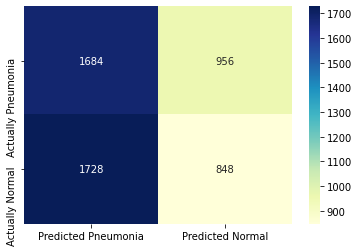

precision - 0.494
recall    - 0.638


Text(0.5, 1.0, 'Receiver Operating Characteristic')

(0.0, 1.0)

(0.0, 1.0)

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 0, 'False Positive Rate')

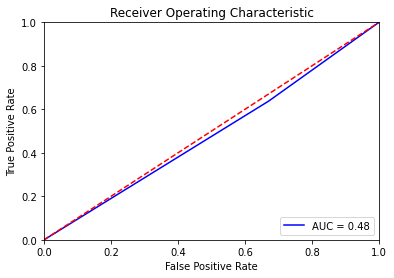

In [163]:
# generate confusion matrix scores
confusion_matrix_scores = confusion_matrix(idx, pred, labels=[1, 0])

# display scores as a heatmap
df = pd.DataFrame(confusion_matrix_scores, 
                  columns = ["Predicted Pneumonia", "Predicted Normal"],
                  index   = ["Actually Pneumonia", "Actually Normal"])

sns.heatmap(df, annot=True, fmt="d", cmap="YlGnBu")
plt.show()

tp, fn, fp, tn = confusion_matrix_scores.ravel()

precision = tp / ( tp + fp )
recall =  tp / ( tp + fn )

print(f'precision - {precision:.3f}')
print(f'recall    - {recall:.3f}')

# ROC plot
# roc_curve(idx, pred, pos_label=1)
fpr, tpr, threshold = roc_curve(idx, pred)
roc_auc = auc(fpr, tpr)

# https://stackoverflow.com/a/38467407
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Sample code... [Ignore]

In [ ]:
X = data['images']

y = data['labels']

output_shape = (80, 80, 1)

# get first image
first_image = X[0,:,:,0]

# display image
plt.imshow(first_image, cmap='gray')
plt.show()

NameError: ignored

In [ ]:
# diplsay the last image in our dataset
last_image = X[-1,:,:,0]
plt.imshow(last_image, cmap='gray')
plt.show()

In [ ]:
# count the frequency of each label
number_of_pneumonia = (y==1).sum()
number_of_normal = (y==0).sum()

print('number of pneumonia images:',number_of_pneumonia)
print('number of normal images:',number_of_normal)

In [ ]:
# import package that will do the train/test split of our data
from sklearn.model_selection import train_test_split

# split out data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [ ]:
# create our neural network model
model = Sequential()

# define each layer 
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(80, 80, 1)))
model.add(Dense(64, activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(Conv2D(32, (3, 3), activation='relu')) # optional 
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile model our model
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [ ]:
# train the model for 2 epochs with our training data, and test using our test data 
training_job = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=8)

In [ ]:
# extract the accuracy on our training data (accuracy) and the accuracy on our
# test data (val_accuracy) as our model was training/learning
train_score = training_job.history['accuracy']
test_score = training_job.history['val_accuracy']

# plot scores
plt.plot(train_score, c='b', label='Train Score')
plt.plot(test_score, c='r', label='Test Score')
plt.ylim(0,1)
plt.legend()
plt.show()

### 16. Let's make a prediction on a single image

In [ ]:
# let's look at the shape of a single image
X_test[0].shape

In [ ]:
# keras is expecting a list of images (even when you only want to predict on one)
# so we need to add an extra dimension onto our image. It's silly but necessary.
np.expand_dims(X_test[0], axis=0).shape

In [ ]:
# view the image we are about to predict on
plt.imshow(X_test[0,:,:,0], cmap='gray')
plt.show()

# get prediction
model.predict(np.expand_dims(X_test[0], axis=0))

## 17. Let's call the `predict_classes` to get a binary output.

In [ ]:
model.predict_classes(np.expand_dims(X_test[0], axis=0))

### Let's compare the the prediction against the actual answer:

In [ ]:
# get the true label stored in y_test
y_test[0]

## 18. Show the probablities/confidence of pneumonia on 20 images from the test data

In [ ]:
data_to_predict = X_test[:200]
probabilitie_of_pneumonia = model.predict(data_to_predict)

print('each line represents a single image')

plt.figure(figsize=(12,5))
plt.scatter(probabilitie_of_pneumonia, np.zeros(len(data_to_predict)),marker='|', alpha=0.5, s=1000)
plt.xlim(0,1)
plt.xlabel('Probability of Pneumonia (raw neural network output)')
plt.show()

if len(probabilitie_of_pneumonia) < 50:
  print(probabilitie_of_pneumonia)

## 19. Show what classification those images would get

In [ ]:
class_predictions = model.predict_classes(data_to_predict)

plt.scatter(probabilitie_of_pneumonia[class_predictions == 1], 
            np.zeros(len(probabilitie_of_pneumonia))[ (class_predictions ==1 ).squeeze()],
            marker='|', alpha=0.8, s=500, label='Pneumonia', c='r')

plt.scatter(probabilitie_of_pneumonia[class_predictions == 0], 
            np.zeros(len(probabilitie_of_pneumonia))[(class_predictions == 0).squeeze()],
            marker='|', alpha=0.8, s=500, label='Normal', c='g')

plt.legend()
plt.xlim(0,1)
plt.xlabel('Probability of Pneumonia')

# draw the decision threshold boundary
plt.axvline(0.5, linestyle='dashed',c='black')

plt.show()

## 20. Let's look at the confusion matrix  

In [ ]:
pred = model.predict_classes(X_test)

# generate confusion matrix scores
confusion_matrix_scores = confusion_matrix(y_test, pred, labels=[1, 0])

# display scores as a heatmap
df = pd.DataFrame(confusion_matrix_scores, 
                  columns = ["Predicted Pneumonia", "Predicted Normal"],
                  index = ["Actually Pneumonia", "Actually Normal"])

sns.heatmap(df, annot=True, fmt="d", cmap="YlGnBu")
plt.show()

## 21. Lets calulate the Precision and Recall

In [ ]:
tp, fn, fp, tn = confusion_matrix_scores.ravel()

precision = tp / ( tp + fp )
recall =  tp / ( tp + fn )

print(f'precision - {precision:.3f}')
print(f'recall    - {recall:.3f}')

# ROC plot
roc_curve(y_test, pred, pos_label=1)
fpr, tpr, threshold = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

# https://stackoverflow.com/a/38467407
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 22. Let's alter the prediction boundary threshold

In [ ]:
prediction_probabilities = model.predict(X_test)

In [ ]:
#@title Move the threshold between 0 and 1 and see how the confusion matrix and precision/recall scores at the bottom change. { run: "auto" }
THRESHOLD = 0.1 #@param {type:"slider", min:0, max:1, step:0.1}

# THRESHOLD = 0.9
prediction_classes = prediction_probabilities>THRESHOLD

# generate confusion matrix scores
confusion_matrix_scores = confusion_matrix(y_test, prediction_classes, labels=[1, 0])

# display scores as a heatmap
df = pd.DataFrame(confusion_matrix_scores, 
                  columns = ["Predicted Pneumonia", "Predicted Normal"],
                  index = ["Actually Pneumonia", "Actually Normal"])

sns.heatmap(df, annot=True, fmt="d", cmap="YlGnBu")
plt.show()


# plt.scatter(prediction_probabilities, np.zeros(len(prediction_probabilities)),marker='|', alpha=0.5, s=500)
# plt.xlim(0,1)
# plt.xlabel('Probibility of Pneumonia')
# plt.show()

# display how the test images are being classified based on their probabilities
plt.scatter(prediction_probabilities[prediction_classes == 1], 
            np.zeros(len(prediction_probabilities))[ (prediction_classes ==1 ).squeeze()],
            marker='|', alpha=0.3, s=500, label='Pneumonia', c='r')

plt.scatter(prediction_probabilities[prediction_classes == 0], 
            np.zeros(len(prediction_probabilities))[(prediction_classes == 0).squeeze()],
            marker='|', alpha=0.3, s=500, label='Normal', c='g')


plt.legend()
plt.xlim(0,1)
plt.xlabel('Probibility of Pneumonia')

# draw the decision threshold boundary
plt.axvline(THRESHOLD, linestyle='dashed',c='black')

plt.show()

# calculate precision and recall
tp, fn, fp, tn = confusion_matrix_scores.ravel()
precision = tp / ( tp + fp )
recall =  tp / ( tp + fn )
print('precision -', precision)
print('recall -', recall)

### 23. When you want to simply "deploy" your model with its new threshold

In [ ]:
# predict as you would normally and compare the output with your desired threshold
pred =  model.predict(X_test) > 0.1

print(f'# Trues:  {np.sum(pred)}')
print(f'# Falses:  {len(pred) - np.sum(pred)}')